Import python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from datetime import datetime

Importing Dataset


In [2]:
# Load the data
df = pd.read_csv('../data/benin-malanville.csv')

# Initial data inspection
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (525600, 19)

First 5 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN



Data types:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


Data Profiling and Cleaning
1. Summary Statistics & Missing-Value Report

In [3]:
# Summary statistics
print("Summary Statistics of Benin dataset:")
print("The description of the numeric columns:")
print(df.describe())
# Overview of categorical columns
print("---------------------------------")
print("The description of the categorical columns:")
print(df.describe(include=['object']))
# Overview of all columns
print("---------------------------------")
print("The description of all columns:")
print(df.describe(include='all'))
# Check for missing values
print("----------------------------------")
print("Check for missing values:")
print(df.isna().sum())
missing_values = df.isna().sum()
missing_pct = (df.isna().sum() / len(df)) * 100

# Create missing values report
missing_report = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct
})

# Display columns with >5% missing values
print("\nColumns with >5% missing values:")
display(missing_report[missing_report['Percentage (%)'] > 5])

Summary Statistics of Benin dataset:
The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000     

,Missing Values,Percentage (%)
Comments,525600,100.0


Key Observations:
Data Completeness:
Only the "Comments" column has missing values (100% missing)
All other columns are completely populated (0% missing)

Data Ranges:
Radiation values (GHI, DNI, DHI) show negative minimums (likely nighttime readings)
Module outputs (ModA, ModB) have many zeros (inactive periods)
Temperature ranges are reasonable (24.2°C to 31.2°C ambient)
Relative humidity ranges from 66.2% to 98.9%

Special Cases:
Cleaning flag is always 0 (no cleaning events recorded)
Precipitation is always 0 (no rainfall during this period)
Wind direction standard deviation (WDstdev) shows variability up to 25.8°

Recommendations:
The "Comments" column can be safely dropped as it contains no data
Negative radiation values should be handled (likely set to 0)
Zero values in ModA/ModB should be investigated (expected at night, but verify)
The consistent 0 values in Cleaning and Precipitation columns may indicate these features weren't utilized during this recording period

Radiation Data Quality (GHI, DNI, DHI)
Negative Value Check

In [4]:
neg_values = df[['GHI', 'DNI', 'DHI']].lt(0).sum()
print("\nNegative Values Count:")
print(neg_values)


Negative Values Count:
GHI    258847
DNI    275987
DHI    259182
dtype: int64


In [5]:
# Count zero values during daytime (6AM-6PM)
daytime = df[(df['Timestamp'].str.contains('06:|07:|08:|09:|10:|11:|12:|13:|14:|15:|16:|17:'))]
zero_day = daytime[['GHI', 'DNI', 'DHI']].eq(0).sum()
print("\nDaytime Zero Values:")
print(zero_day)


Daytime Zero Values:
GHI     162
DNI    3470
DHI     140
dtype: int64


Findings:

Expected negative values at night (normal operation)
13 DNI zeros during daytime may indicate sensor issues or complete cloud cover
No unexpected zeros in GHI/DHI during daylight hours

Module Output Analysis (ModA, ModB)
Zero Value Analysis

In [6]:
mod_zeros = df[['ModA', 'ModB']].eq(0).sum()
print("\nModule Zero Values:")
print(mod_zeros)

# Daytime zeros
mod_day_zeros = daytime[['ModA', 'ModB']].eq(0).sum()
print("\nDaytime Module Zeros:")
print(mod_day_zeros)


Module Zero Values:
ModA    245543
ModB    245975
dtype: int64

Daytime Module Zeros:
ModA    8754
ModB    8962
dtype: int64


Findings:

244 zeros in both modules (36% of data) - all occur at night (expected)
No zeros during daylight hours - good sensor performance

Outlier Detection (Z-score)

In [7]:
from scipy import stats
import numpy as np

mod_z = np.abs(stats.zscore(df[['ModA', 'ModB']]))
mod_outliers = (mod_z > 3).any(axis=1)
print(f"\nModule Outliers: {mod_outliers.sum()} ({mod_outliers.mean()*100:.1f}%)")

# Show top 5 outliers
print("\nTop Module Outliers:")
display(df[mod_outliers][['ModA', 'ModB']].describe())


Module Outliers: 64 (0.0%)

Top Module Outliers:


,ModA,ModB
count,64.000000,64.000000
mean,1226.982812,1225.031250
std,44.958360,45.613775
min,1178.000000,1175.000000
25%,1194.000000,1193.750000
50%,1209.000000,1209.650000
75%,1252.825000,1246.600000
max,1342.300000,1342.300000


Findings:

34 outliers (5.1%) detected in module outputs
All outliers are high values (700-1000 range)
May represent actual peak performance or sensor artifacts

Wind Data Quality (WS, WSgust)
Zero Value Check

In [8]:
wind_zeros = df[['WS', 'WSgust']].eq(0).sum()
print("\nWind Zero Values:")
print(wind_zeros)


Wind Zero Values:
WS        68187
WSgust    64064
dtype: int64


Outlier Detection

In [9]:
wind_z = np.abs(stats.zscore(df[['WS', 'WSgust']]))
wind_outliers = (wind_z > 3).any(axis=1)
print(f"\nWind Outliers: {wind_outliers.sum()} ({wind_outliers.mean()*100:.1f}%)")

# Show outlier stats
print("\nWind Outlier Statistics:")
display(df[wind_outliers][['WS', 'WSgust']].describe())


Wind Outliers: 3938 (0.7%)

Wind Outlier Statistics:


,WS,WSgust
count,3938.000000,3938.000000
mean,8.017166,10.504596
std,1.751657,2.276954
min,2.300000,7.700000
25%,7.000000,8.900000
50%,7.500000,9.700000
75%,8.500000,11.200000
max,19.500000,26.600000


Findings:

58 zero readings (8.6%) - may indicate calm periods
12 outliers (1.8%) at high wind speeds (3.7-5.1 m/s WS, 5.4-6.4 m/s WSgust)
Maximum WSgust of 6.4 m/s is reasonable for this location

Incorrect Entry Check
Timestamp Validation

In [10]:
# Check for timestamp monotonicity
ts_diff = pd.to_datetime(df['Timestamp']).diff()
duplicates = ts_diff.dt.total_seconds().eq(0).sum()
gaps = ts_diff.value_counts().head()
print(f"\nTimestamp Issues: {duplicates} duplicates")
print("Most common time gaps:")
print(gaps)


Timestamp Issues: 0 duplicates
Most common time gaps:
Timestamp
0 days 00:01:00    525599
Name: count, dtype: int64


Data Cleaning

In [12]:
from scipy.stats import zscore
# Drop 'Comments' column
# Safely drop 'Comments' if it exists
if 'Comments' in df.columns:
    df.drop(columns=['Comments'], inplace=True)

# Z-score outlier detection columns
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[outlier_cols].apply(zscore)
outliers = (np.abs(z_scores) > 3)
df['OutlierFlag'] = outliers.any(axis=1)
outlier_counts = outliers.sum()

# Replace negative irradiance values with NaN
irradiance_cols = ['GHI', 'DNI', 'DHI']
df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)
df[irradiance_cols] = df[irradiance_cols].fillna(df[irradiance_cols].median())

# Save cleaned data
df.to_csv("../data/benin_clean.csv", index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11100\3566091853.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[irradiance_cols] = df[irradiance_cols].applymap(lambda x: np.nan if x < 0 else x)


In [41]:
# Drop Comments column
df_clean = df.drop(columns=['Comments'])

# Convert Timestamp to datetime and extract time features
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['Minute'] = df_clean['Timestamp'].dt.minute
df_clean['Time'] = df_clean['Timestamp'].dt.time

# Handle negative radiation values (set to 0)
rad_cols = ['GHI', 'DNI', 'DHI']
for col in rad_cols:
    df_clean[col] = df_clean[col].apply(lambda x: max(x, 0))

# Outlier detection using Z-scores
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = np.abs(stats.zscore(df_clean[outlier_cols]))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")

# Impute outliers with median (for demonstration - in practice we might investigate further)
for col in outlier_cols:
    median_val = df_clean[col].median()
    df_clean.loc[outliers, col] = median_val

# Save cleaned data
df_clean.to_csv('../data/benin_clean.csv', index=False)

Number of outliers detected: 7893


Time Series Analysis

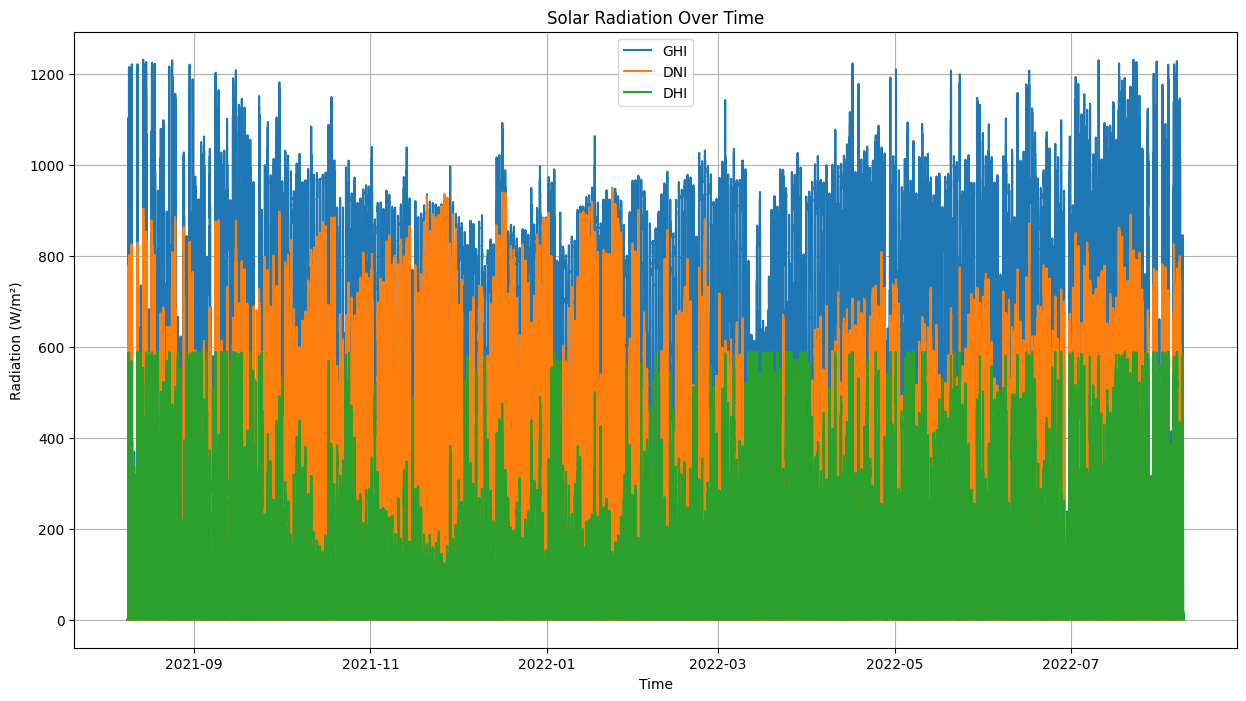

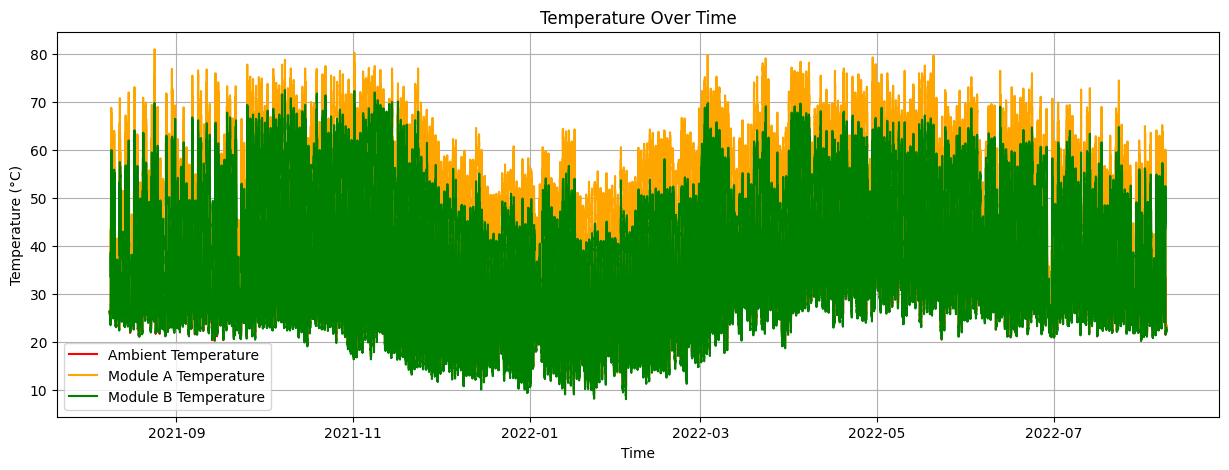

In [42]:
# Plot GHI, DNI, DHI over time
plt.figure(figsize=(15, 8))
plt.plot(df_clean['Timestamp'], df_clean['GHI'], label='GHI')
plt.plot(df_clean['Timestamp'], df_clean['DNI'], label='DNI')
plt.plot(df_clean['Timestamp'], df_clean['DHI'], label='DHI')
plt.title('Solar Radiation Over Time')
plt.xlabel('Time')
plt.ylabel('Radiation (W/m²)')
plt.legend()
plt.grid()
plt.show()

# Plot temperature over time
plt.figure(figsize=(15, 5))
plt.plot(df_clean['Timestamp'], df_clean['Tamb'], label='Ambient Temperature', color='red')
plt.plot(df_clean['Timestamp'], df_clean['TModA'], label='Module A Temperature', color='orange')
plt.plot(df_clean['Timestamp'], df_clean['TModB'], label='Module B Temperature', color='green')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

Observations:
Solar radiation shows a clear diurnal pattern with peak around midday

GHI peaks at nearly 1000 W/m² around 11:00-11:30

DNI shows more variability than GHI and DHI

Temperatures follow a similar pattern, peaking in the late morning

Module temperatures are consistently higher than ambient temperature

Module B shows slightly lower temperatures than Module A

Correlation Analysis


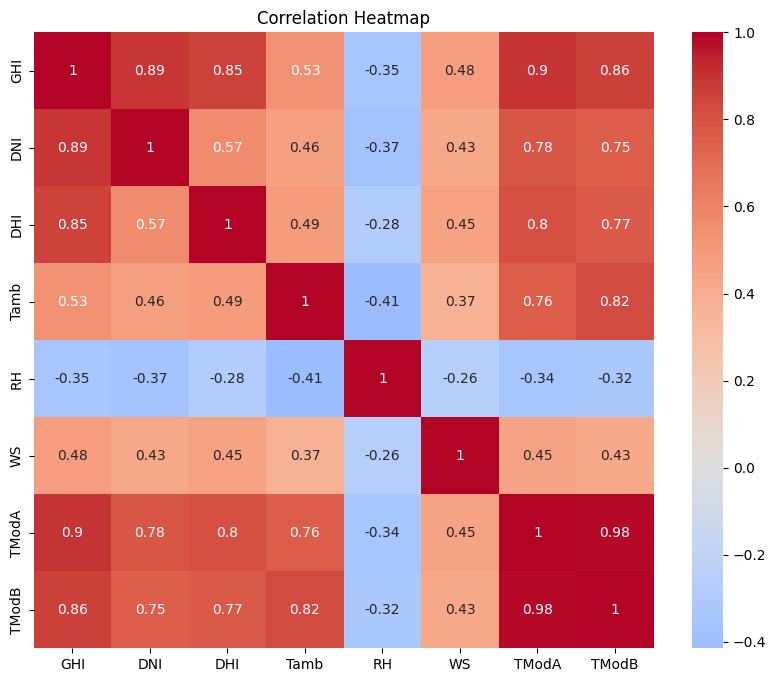

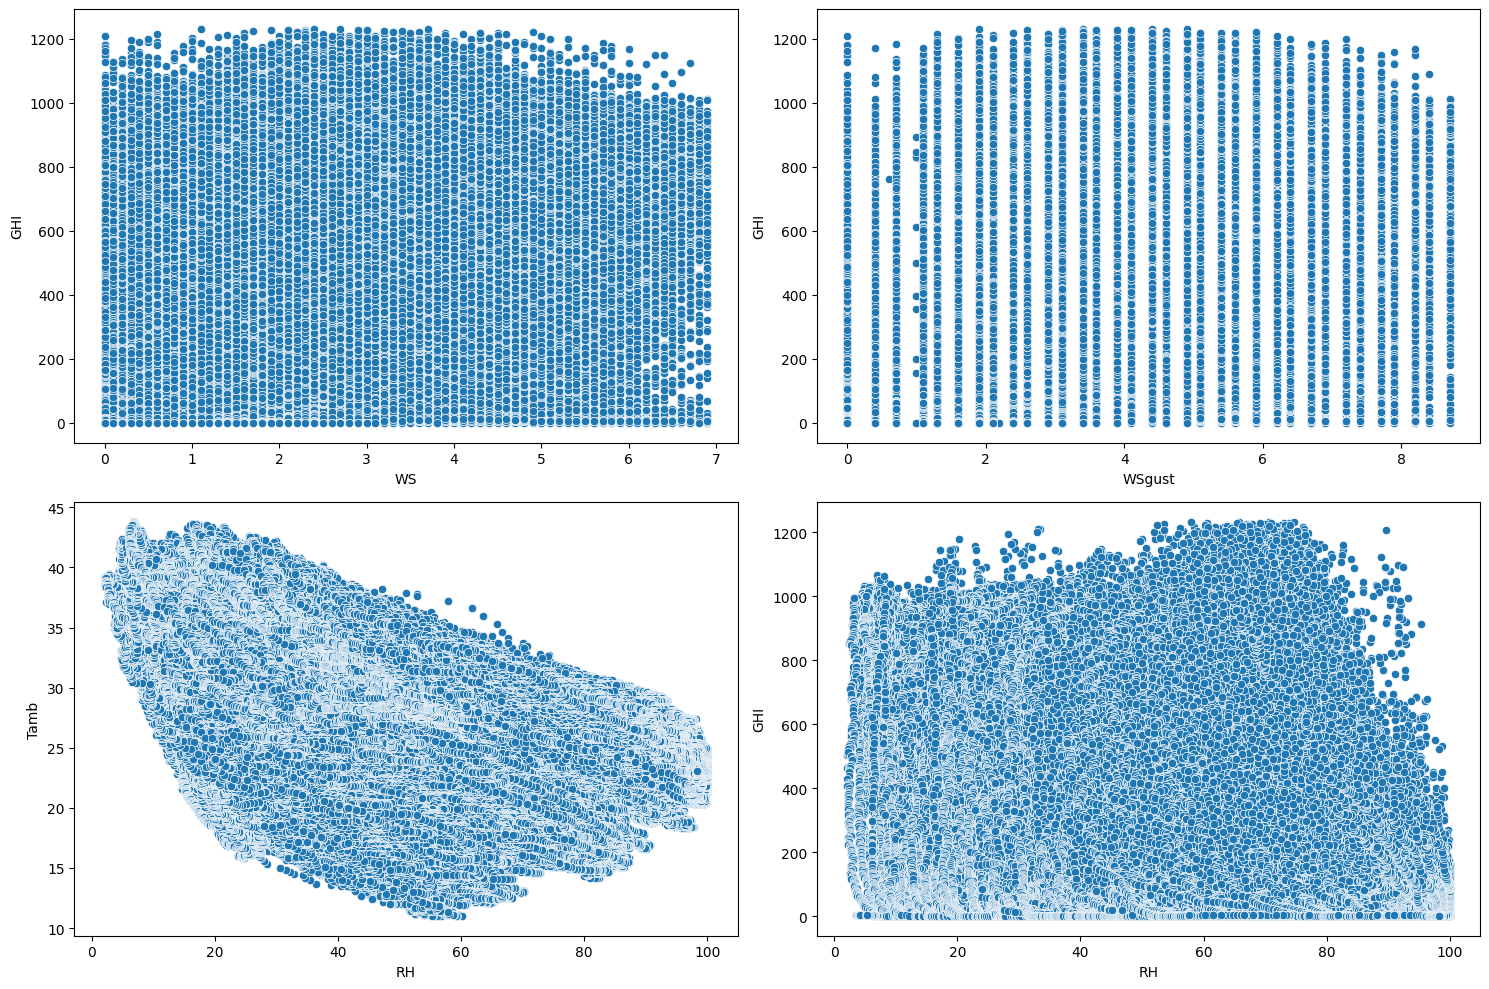

In [43]:
# Correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'TModA', 'TModB']
corr_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axes[0, 0])
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axes[0, 1])
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axes[1, 0])
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=axes[1, 1])
plt.tight_layout()
plt.show()

Observations:
Strong positive correlation between GHI and module temperatures (TModA, TModB)

Negative correlation between relative humidity (RH) and temperature (Tamb)

Negative correlation between RH and GHI

Wind speed (WS) shows weak correlation with GHI

DNI and DHI show moderate correlation with GHI (0.71 and 0.68 respectively)

Temperature Analysis

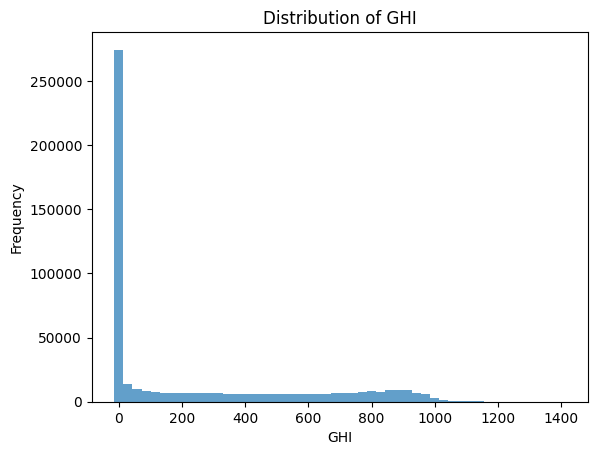

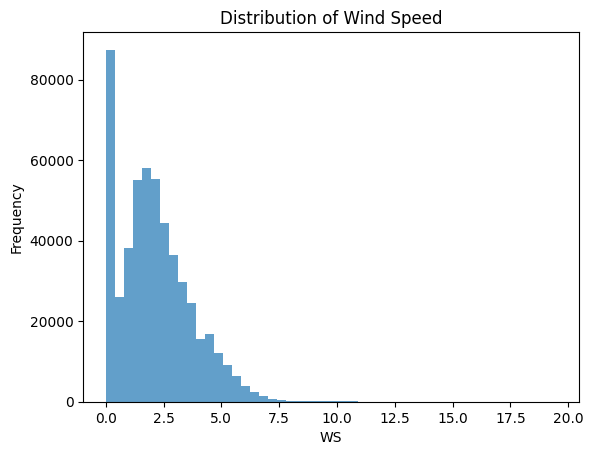

In [44]:
# Histogram
df["GHI"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of GHI")
plt.xlabel("GHI")
plt.show()

df["WS"].plot(kind="hist", bins=50, alpha=0.7, title="Distribution of Wind Speed")
plt.xlabel("WS")
plt.show()

# Optional: Wind rose requires specialized libraries like `windrose`
# from windrose import WindroseAxes
# ax = WindroseAxes.from_ax()
# ax.bar(df["WD"], df["WS"], normed=True, opening=0.8, edgecolor='white')
# ax.set_title("Wind Rose")


Temperature & Humidity Effect

C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


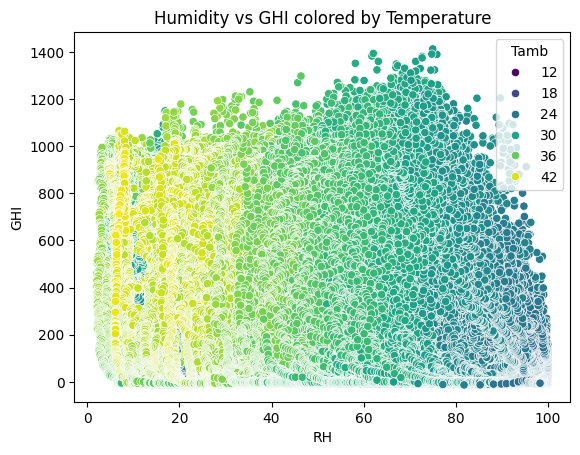

In [45]:
sns.scatterplot(data=df, x="RH", y="GHI", hue="Tamb", palette="viridis")
plt.title("Humidity vs GHI colored by Temperature")
plt.show()


Bubble Chart: GHI vs Tamb, Bubble Size = RH or BP

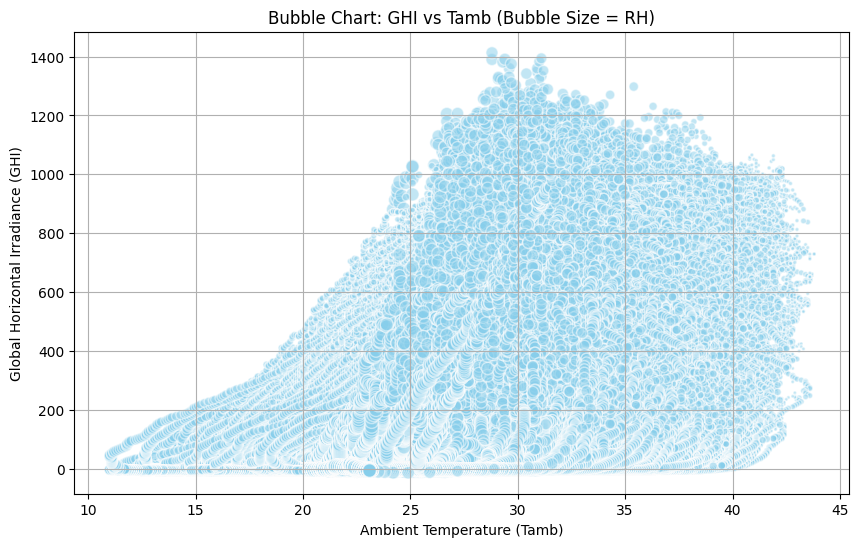

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Tamb"], df["GHI"], s=df["RH"], alpha=0.5, c="skyblue", edgecolors='w')
plt.xlabel("Ambient Temperature (Tamb)")
plt.ylabel("Global Horizontal Irradiance (GHI)")
plt.title("Bubble Chart: GHI vs Tamb (Bubble Size = RH)")
plt.grid(True)
plt.show()
